# Test the photometry functionality and compare output...

### Get background using sigma clipped stats

Mean: 2831.8837890625, Median: 2831.155517578125, SD: 61.87967300415039


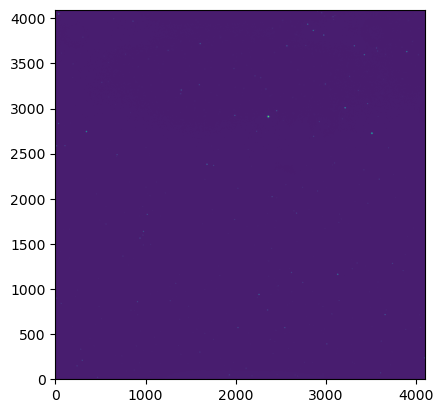

In [1]:
import photutils as pht
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt

data=fits.getdata('/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_1.fit')
## here we can show some statistics about the sky
plt.imshow(data, origin='lower')
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
print(f"Mean: {mean}, Median: {median}, SD: {std}")

### get the background mask/map

/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


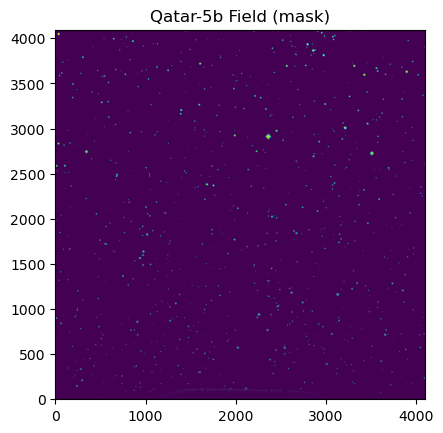

In [2]:
from photutils.segmentation import detect_sources
import matplotlib.pyplot as plt

segm = detect_sources(data-mean, 3*std, npixels=5)
#flipping here causes no issue, why does flipping data cause problems? should we flip flat/bias...
plt.imshow(segm.data, origin = 'lower')

plt.title("Qatar-5b Field (mask)")
plt.savefig("field_mask_plot.png")

### Convert the segmentation image to a numpy array, this can serve as mask, 

Text(0.5, 1.0, 'Boolean Sky Mask')

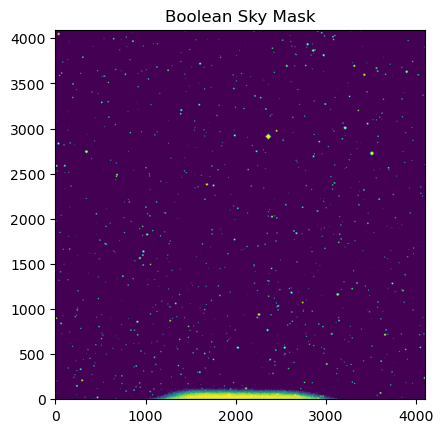

In [3]:
bool_array = segm.data != 0 
plt.imshow(bool_array, origin='lower')
plt.title('Boolean Sky Mask')

In [4]:
from astropy.stats import SigmaClip
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = pht.background.SExtractorBackground()
bkg = pht.background.Background2D(data, (64, 64), mask=bool_array,filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

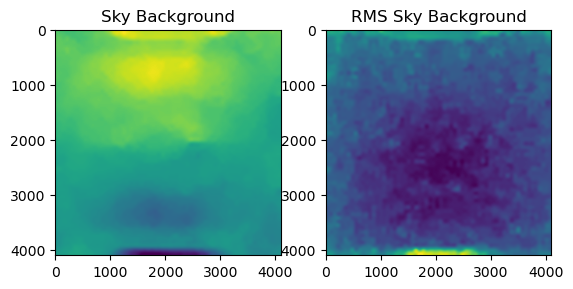

In [5]:
fig, axs = plt.subplots(1,2)
axs[0].set_title('Sky Background')
axs[0].imshow(bkg.background)
axs[1].set_title('RMS Sky Background')
axs[1].imshow(bkg.background_rms)

In [6]:
from photutils.detection import IRAFStarFinder

threshold_multiplier=10.0
daofind = IRAFStarFinder(fwhm=3.0, threshold=threshold_multiplier*bkg.background_rms_median,exclude_border=True, sharplo=0.5, sharphi=2.0, roundlo=0.0, roundhi=0.7)
sources = daofind(data - bkg.background_median)
print(sources)

 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2914.6213690262116 ... 4076.6076049804688  -9.025747275813911
  2  471.9253869850101 ...   46238.5556640625 -11.662510649337603
  3 1779.0412342036625 ...   1159.74365234375  -7.660905010403967
  4  2686.790425508937 ... 22075.305419921875 -10.859766802285302
  5 2970.7315842965827 ...     4404.544921875  -9.109752609266218
  6 2180.7980010276983 ...  15182.02001953125   -10.4533238994142
  7 3566.1533392700994 ...  5005.826904296875  -9.248689570327727
  8  2658.886895206944 ...     16681.27734375 -10.555573257556198
  9 1930.0162173931808 ...   63153.6455078125  -12.00099606253441
 10  36.05349447442792 ...  1417.788080215454   -7.87902830195706
...                ... ...                ...                 ...
650  882.1460804690729 ...  1973.723876953125  -8.238215987470976
651 2203.6155867194043 ... 3335.5062255859375  -8.807904388955613
652 1701.0

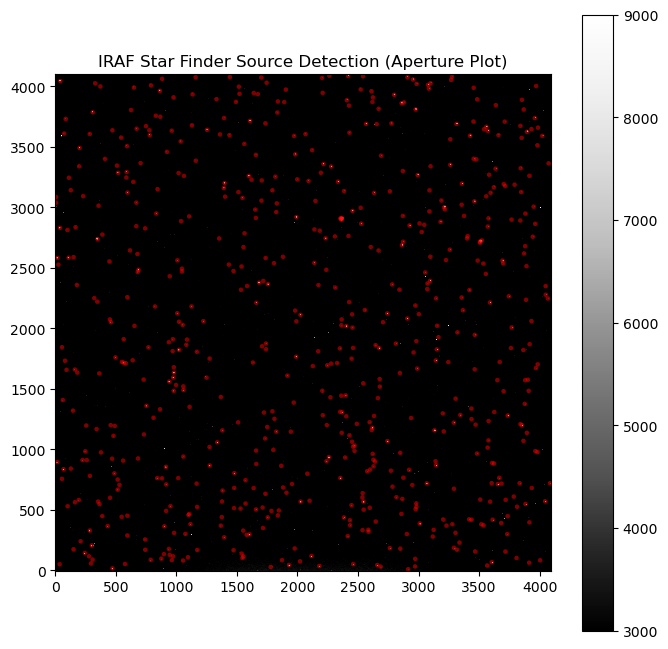

In [7]:
from photutils.aperture import CircularAperture
import numpy as np
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=10.)
plt.figure(figsize=(8,8))
plt.imshow(data, cmap='Greys_r', origin='lower', vmin=3000, vmax=9000, interpolation='nearest')
plt.colorbar()
plt.title("IRAF Star Finder Source Detection (Aperture Plot)")
apertures.plot(color='red', lw=1.5, alpha=0.5)

### Error estimation, including poisson error, for given image:

In [ ]:
from photutils.utils import calc_total_error

gain=0.242759602
error=calc_total_error(data-bkg.background, bkg.background_rms, gain)
print(np.median(error))
print(sources)
print(sources.colnames)

49.86628
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2914.6213690262116 ... 4076.6076049804688  -9.025747275813911
  2  471.9253869850101 ...   46238.5556640625 -11.662510649337603
  3 1779.0412342036625 ...   1159.74365234375  -7.660905010403967
  4  2686.790425508937 ... 22075.305419921875 -10.859766802285302
  5 2970.7315842965827 ...     4404.544921875  -9.109752609266218
  6 2180.7980010276983 ...  15182.02001953125   -10.4533238994142
  7 3566.1533392700994 ...  5005.826904296875  -9.248689570327727
  8  2658.886895206944 ...     16681.27734375 -10.555573257556198
  9 1930.0162173931808 ...   63153.6455078125  -12.00099606253441
 10  36.05349447442792 ...  1417.788080215454   -7.87902830195706
...                ... ...                ...                 ...
650  882.1460804690729 ...  1973.723876953125  -8.238215987470976
651 2203.6155867194043 ... 3335.5062255859375  -8.807904388955613
6